# Data Science Pipeline: Predicción de Pedidos Digitales en eB2B

Este notebook contiene la implementación completa del pipeline de Ciencia de Datos, desde el pre-procesamiento hasta la construcción de varios modelos para calcular la probabilidad de que los clientes usen la plataforma digital para realizar pedidos.

In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


In [2]:
# Loading the data set
raw = pl.read_parquet("../data/*.parquet")
print(type(raw))
raw.head()

<class 'polars.dataframe.frame.DataFrame'>


cliente_id,pais_cd,region_comercial_txt,agencia_id,ruta_id,tipo_cliente_cd,madurez_digital_cd,estrellas_txt,frecuencia_visitas_cd,fecha_pedido_dt,canal_pedido_cd,facturacion_usd_val,materiales_distintos_val,cajas_fisicas
str,str,str,str,str,str,str,str,str,datetime[ns],str,f64,i64,f64
"""C125500""","""EC""","""COSTA""","""EC-COS-A003""","""EC-COS-A003-R002""","""MINIMARKET""","""BAJA""","""1""","""L""",2023-10-04 00:00:00,"""TELEFONO""",141.59,6,11.62
"""C009622""","""GT""","""METROPOLITANA""","""GT-MET-A003""","""GT-MET-A003-R014""","""MINIMARKET""","""ALTA""","""2""","""LMV""",2023-03-20 00:00:00,"""DIGITAL""",86.03,11,14.74
"""C115462""","""EC""","""SIERRA""","""EC-SIE-A005""","""EC-SIE-A005-R004""","""TIENDA""","""ALTA""","""3""","""LMI""",2023-11-09 00:00:00,"""VENDEDOR""",143.49,7,17.34
"""C057515""","""PE""","""SELVA""","""PE-SEL-A001""","""PE-SEL-A001-R011""","""TIENDA""","""BAJA""","""1""","""LM""",2023-11-28 00:00:00,"""DIGITAL""",43.94,4,17.15
"""C143306""","""SV""","""OCCIDENTE""","""SV-OCC-A006""","""SV-OCC-A006-R014""","""MINIMARKET""","""BAJA""","""3""","""LMV""",2023-04-04 00:00:00,"""DIGITAL""",184.35,10,23.46


In [3]:
# Dimensions of df
n_rows, n_cols = raw.shape
print(raw.shape)

# Column names
print(raw.columns)

(1250000, 14)
['cliente_id', 'pais_cd', 'region_comercial_txt', 'agencia_id', 'ruta_id', 'tipo_cliente_cd', 'madurez_digital_cd', 'estrellas_txt', 'frecuencia_visitas_cd', 'fecha_pedido_dt', 'canal_pedido_cd', 'facturacion_usd_val', 'materiales_distintos_val', 'cajas_fisicas']


In [4]:
# Getting a subset of df (only desired columns)
df = raw.select([
    "cliente_id",
    "pais_cd",
    "fecha_pedido_dt",
    "canal_pedido_cd",
    "facturacion_usd_val",
    "materiales_distintos_val",
    "frecuencia_visitas_cd"
])
print(df.schema)
df.head()

Schema({'cliente_id': String, 'pais_cd': String, 'fecha_pedido_dt': Datetime(time_unit='ns', time_zone=None), 'canal_pedido_cd': String, 'facturacion_usd_val': Float64, 'materiales_distintos_val': Int64, 'frecuencia_visitas_cd': String})


cliente_id,pais_cd,fecha_pedido_dt,canal_pedido_cd,facturacion_usd_val,materiales_distintos_val,frecuencia_visitas_cd
str,str,datetime[ns],str,f64,i64,str
"""C125500""","""EC""",2023-10-04 00:00:00,"""TELEFONO""",141.59,6,"""L"""
"""C009622""","""GT""",2023-03-20 00:00:00,"""DIGITAL""",86.03,11,"""LMV"""
"""C115462""","""EC""",2023-11-09 00:00:00,"""VENDEDOR""",143.49,7,"""LMI"""
"""C057515""","""PE""",2023-11-28 00:00:00,"""DIGITAL""",43.94,4,"""LM"""
"""C143306""","""SV""",2023-04-04 00:00:00,"""DIGITAL""",184.35,10,"""LMV"""


## EDA

In [5]:
# Summary statistics 
print(df.describe())

# df['frecuencia_visitas_cd'].value_counts()

shape: (9, 8)
┌────────────┬────────────┬─────────┬────────────┬────────────┬────────────┬───────────┬───────────┐
│ statistic  ┆ cliente_id ┆ pais_cd ┆ fecha_pedi ┆ canal_pedi ┆ facturacio ┆ materiale ┆ frecuenci │
│ ---        ┆ ---        ┆ ---     ┆ do_dt      ┆ do_cd      ┆ n_usd_val  ┆ s_distint ┆ a_visitas │
│ str        ┆ str        ┆ str     ┆ ---        ┆ ---        ┆ ---        ┆ os_val    ┆ _cd       │
│            ┆            ┆         ┆ str        ┆ str        ┆ f64        ┆ ---       ┆ ---       │
│            ┆            ┆         ┆            ┆            ┆            ┆ f64       ┆ str       │
╞════════════╪════════════╪═════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╡
│ count      ┆ 1250000    ┆ 1250000 ┆ 1250000    ┆ 1250000    ┆ 1.25e6     ┆ 1.25e6    ┆ 1250000   │
│ null_count ┆ 0          ┆ 0       ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0       ┆ 0         │
│ mean       ┆ null       ┆ null    ┆ 2023-10-28 ┆ null       ┆ 120.323333 ┆ 

In [6]:
# Double-checking if there are any NAs
null_counts: dict = df.null_count()
print(null_counts)

shape: (1, 7)
┌────────────┬─────────┬───────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ cliente_id ┆ pais_cd ┆ fecha_pedido_ ┆ canal_pedido ┆ facturacion_ ┆ materiales_d ┆ frecuencia_v │
│ ---        ┆ ---     ┆ dt            ┆ _cd          ┆ usd_val      ┆ istintos_val ┆ isitas_cd    │
│ u32        ┆ u32     ┆ ---           ┆ ---          ┆ ---          ┆ ---          ┆ ---          │
│            ┆         ┆ u32           ┆ u32          ┆ u32          ┆ u32          ┆ u32          │
╞════════════╪═════════╪═══════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 0          ┆ 0       ┆ 0             ┆ 0            ┆ 0            ┆ 0            ┆ 0            │
└────────────┴─────────┴───────────────┴──────────────┴──────────────┴──────────────┴──────────────┘


In [7]:
# Transforming polar df to pandas df 
df_pd = df.to_pandas()
print(df_pd.info())
df_pd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250000 entries, 0 to 1249999
Data columns (total 7 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   cliente_id                1250000 non-null  object        
 1   pais_cd                   1250000 non-null  object        
 2   fecha_pedido_dt           1250000 non-null  datetime64[ns]
 3   canal_pedido_cd           1250000 non-null  object        
 4   facturacion_usd_val       1250000 non-null  float64       
 5   materiales_distintos_val  1250000 non-null  int64         
 6   frecuencia_visitas_cd     1250000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 66.8+ MB
None


,cliente_id,pais_cd,fecha_pedido_dt,canal_pedido_cd,facturacion_usd_val,materiales_distintos_val,frecuencia_visitas_cd
0,C125500,EC,2023-10-04,TELEFONO,141.59,6,L
1,C009622,GT,2023-03-20,DIGITAL,86.03,11,LMV
2,C115462,EC,2023-11-09,VENDEDOR,143.49,7,LMI
3,C057515,PE,2023-11-28,DIGITAL,43.94,4,LM
4,C143306,SV,2023-04-04,DIGITAL,184.35,10,LMV


### Memory Optimization

In [8]:
# Memory Optimization (categorical var)
col_cat = df_pd.select_dtypes(include=object).columns

for cat in col_cat:
    df_pd[cat] = df_pd[cat].astype("category")

df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250000 entries, 0 to 1249999
Data columns (total 7 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   cliente_id                1250000 non-null  category      
 1   pais_cd                   1250000 non-null  category      
 2   fecha_pedido_dt           1250000 non-null  datetime64[ns]
 3   canal_pedido_cd           1250000 non-null  category      
 4   facturacion_usd_val       1250000 non-null  float64       
 5   materiales_distintos_val  1250000 non-null  int64         
 6   frecuencia_visitas_cd     1250000 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(1), int64(1)
memory usage: 42.1 MB


In [9]:
# Memory Optimization (numerical var)
df_pd["facturacion_usd_val"] = pd.to_numeric(df_pd["facturacion_usd_val"], downcast="float") # float64 to float32

df_pd["materiales_distintos_val"] = pd.to_numeric(df_pd["materiales_distintos_val"], downcast="unsigned") # int64 to smallest int

df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250000 entries, 0 to 1249999
Data columns (total 7 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   cliente_id                1250000 non-null  category      
 1   pais_cd                   1250000 non-null  category      
 2   fecha_pedido_dt           1250000 non-null  datetime64[ns]
 3   canal_pedido_cd           1250000 non-null  category      
 4   facturacion_usd_val       1250000 non-null  float32       
 5   materiales_distintos_val  1250000 non-null  uint8         
 6   frecuencia_visitas_cd     1250000 non-null  category      
dtypes: category(4), datetime64[ns](1), float32(1), uint8(1)
memory usage: 29.0 MB


### Numerical variables

In [10]:
# List of numerical variables
col_num = df_pd.select_dtypes(include="number").columns

# Summary statistics of numerical variables
df_pd[col_num].describe().T

,count,mean,std,min,25%,50%,75%,max
facturacion_usd_val,1250000.0,120.323326,49.353603,0.0,86.360001,120.080002,153.759995,366.380005
materiales_distintos_val,1250000.0,7.500517,4.031994,1.0,4.000000,8.000000,11.000000,14.000000


#### Histograms

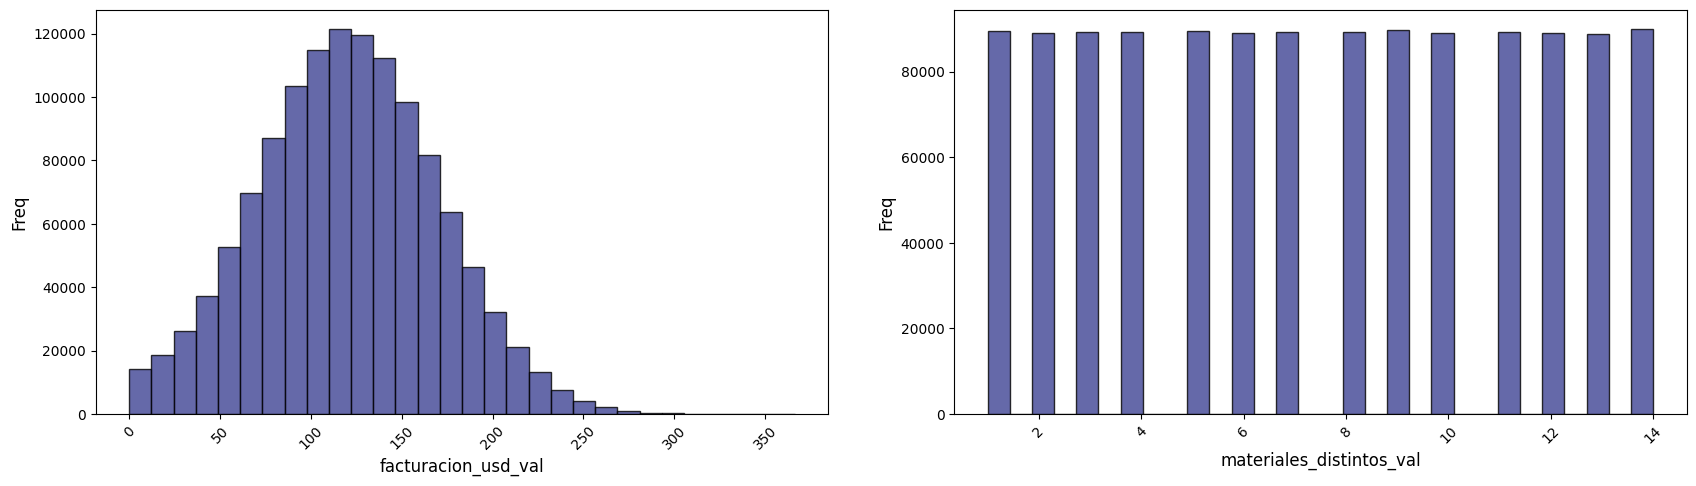

In [11]:
num_plots = len(col_num) # Number of plots

# Creating subplots
fig, axes = plt.subplots(1, num_plots, figsize=(18, 6))

fig.tight_layout(pad=6)  # Spacing between subplots

# Iterate over columns and create histograms
for ax, column in zip(axes, col_num):
    ax.hist(
        df_pd[column],
        bins=30,
        stacked=True,
        edgecolor="black",
        color="#3f4394",
        alpha=0.8)

    ax.set_xlabel(column, size=12)
    ax.set_ylabel("Freq", size=12)
    ax.tick_params(axis="x", rotation=45)  # Rotation of x-axis labels

plt.show()

#### Box-plots

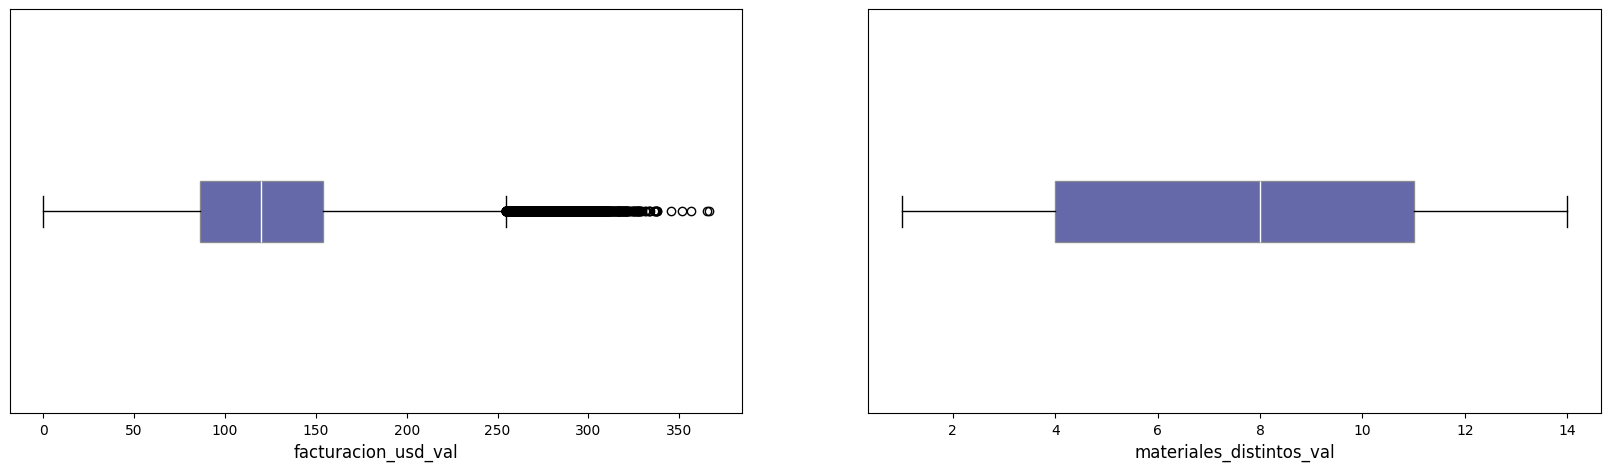

In [12]:
num_plots = len(col_num) # Number of plots

# Creating subplots
fig, axes = plt.subplots(1, num_plots, figsize=(18, 6))

fig.tight_layout(pad=6)  # Spacing between subplots

# Iterate over columns and create histograms
for ax, column in zip(axes, col_num):
    ax.boxplot(
        df_pd[column],
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor="#3f4394", edgecolor="grey", alpha=0.8),
        medianprops=dict(color="white")   # median line color
    )
    ax.set_xlabel(column, size=12)
    ax.set_yticks([])  # hide the y-axis ticks

plt.show()

### Categorical variables

In [13]:
# Summary statistics of categorical variables
df_pd.describe(include=["category"])

,cliente_id,pais_cd,canal_pedido_cd,frecuencia_visitas_cd
count,1250000,1250000,1250000,1250000
unique,149960,4,3,4
top,C002719,EC,DIGITAL,LM
freq,25,313846,599238,314068


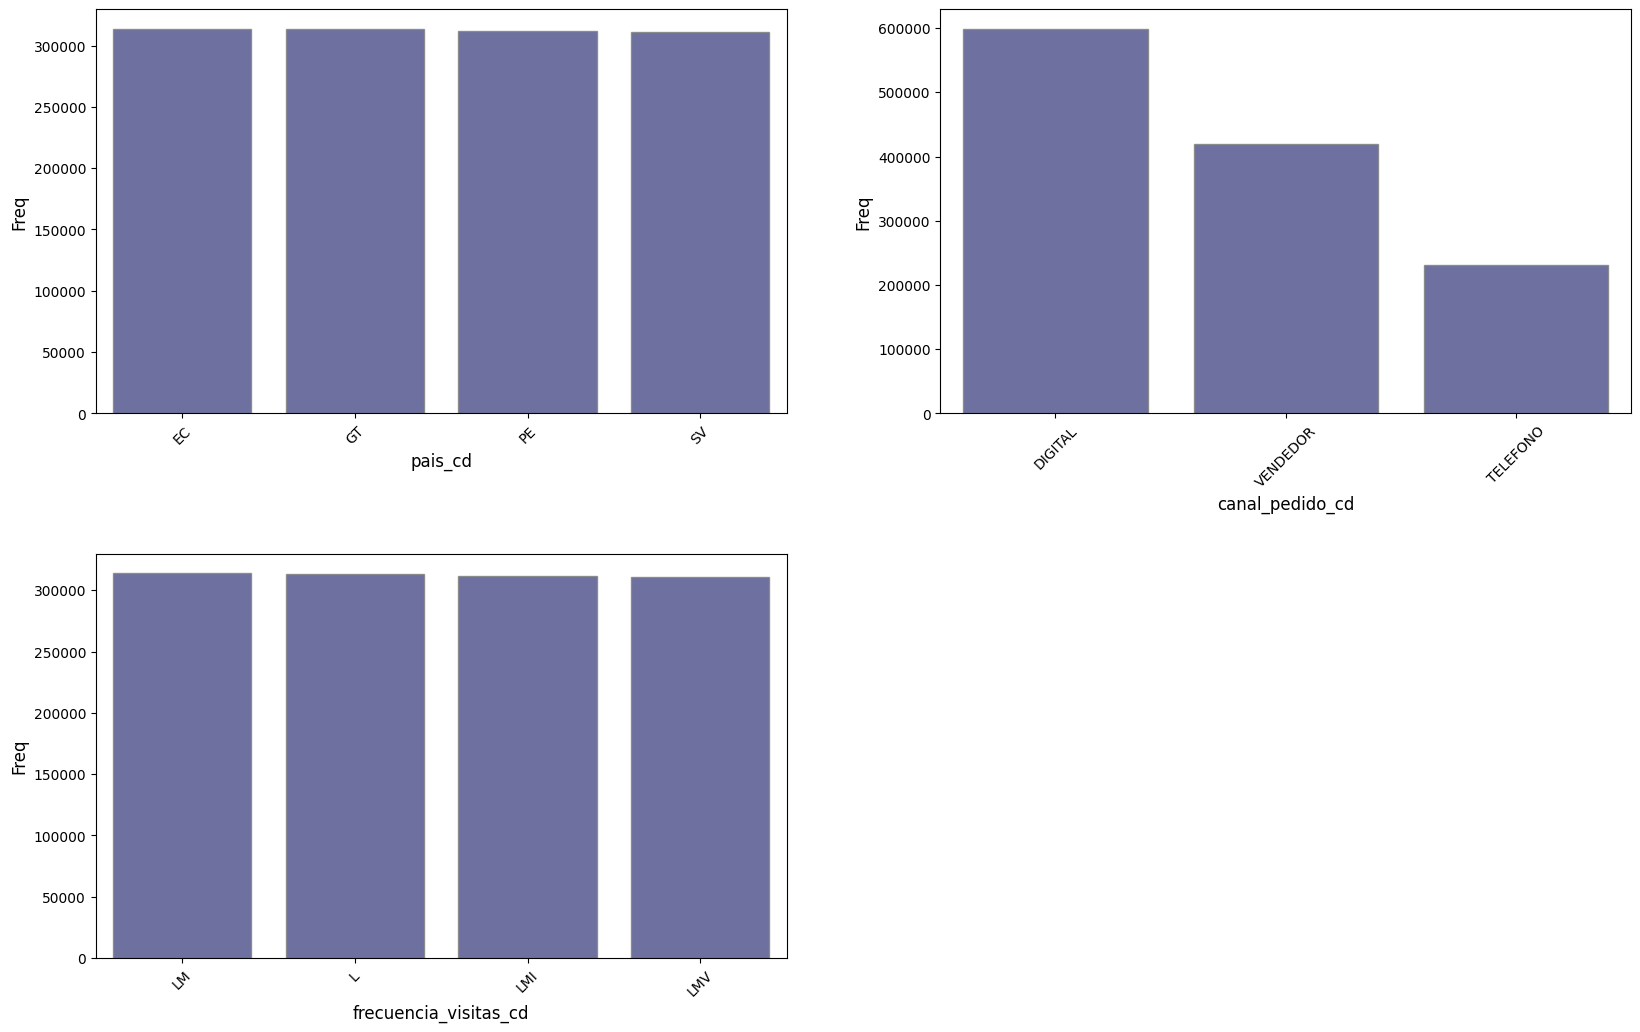

In [14]:
# BAR PLOTS
col_bar = list(col_cat)[1:] # categorical variables without 'cliente_id'
num_plots = len(col_bar) # Number of plots
num_cols = 2  # Number of columns in the grid layout
num_rows = (num_plots - 1) // num_cols + 1 # Number of rows in the grid layout

# Creating subplots
fig, axs = plt.subplots(num_rows, num_cols,
                        figsize=(18, 6 * num_rows))

if num_rows == 1:
    axs = axs.reshape(1, -1)
if num_cols == 1:
    axs = axs.reshape(-1, 1)

fig.tight_layout(pad=8)  # Spacing between subplots

for i, column in enumerate(col_bar):
    ax = axs[i // num_cols, i % num_cols]
    sns.countplot(
        x=column,
        data=df_pd,
        color="#3f4394",
        edgecolor="grey",
        alpha=0.8,
        order=df_pd[column].value_counts().index,
        ax=ax)
    ax.set_xlabel(column, size=12)
    ax.set_ylabel("Freq", size=12)
    ax.tick_params(axis="x", rotation=45)

if num_plots % num_cols != 0:
    for j in range(num_plots % num_cols, num_cols):
        fig.delaxes(axs[num_rows - 1, j])

plt.show()

## Feature Engineering

Cada fila del set representa un pedido; sin embargo, se solicita modelar a nivel cliente. Por lo que se propone unir/aggregate ciertas variables y crear nuevas. De esta forma la data que alimentará a los modelos estará por cliente y no órdenes.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Finding if clients are present in multiple countries
# Count of distinct countries per client
country_counts = (
    df_pd
      .groupby("cliente_id")["pais_cd"]
      .nunique()
      .rename("n_countries")
)

# Determine if a client is present in more than one country (>1)
multi_country_clients = country_counts[country_counts > 1].index.tolist()

print(f"Found {len(multi_country_clients)} clients in more than one country:")

Found 0 clients in more than one country:


In [17]:
# Finding if clients have more than one category of 'frecuencia_visitas_cd'
# Count of distinct visitas per client
visitas_counts = (
    df_pd
      .groupby("cliente_id")["frecuencia_visitas_cd"]
      .nunique()
      .rename("n_visitas")
)

# Determine if a client is present in more than one category of 'frecuencia_visitas_cd' 
multi_visitas_clients = visitas_counts[visitas_counts > 1].index.tolist()
print(f"Found {len(multi_visitas_clients)} clients in more than one category of 'frecuencia_visitas_cd':")

Found 0 clients in more than one category of 'frecuencia_visitas_cd':


### Notas
- Dado que se encontró que los clientes pertenecen a un solo país, así como a un tipo de visita, se determina que estas variables están a nivel cliente y pueden ser agregadas sin mayor complejidad.
- Se propone construir una variable que indique la cantidad de pedidos que se hicieron a través del medio digital. Además, es posible calcular la proporción de pedidos hechos digitalmente sobre el total de pedidos.
- El EDA reveló que la facturación posee una forma de campana, relativamente. El histograma presenta valores atípicos del lado derecho. Por lo tanto para poder agregar la fx por cliente, minimizando el efecto de los valores "anormales", se opta por usar la mediana y no la media. 
- La distribución de 'materiales_distintos' es relativamente uniforme. Esto sugiere que los pedidos se distribuyen de manera equitativa en cuanto a “cuántos materiales diferentes” compran. 
- Se estima valioso crear una variable que indique recencia por cliente.

In [18]:
# Feature engineering per client
df_cliente = df_pd.groupby("cliente_id").agg(
    pais=("pais_cd", "first"),
    total_pedidos=("canal_pedido_cd", "count"),
    pedidos_digital=("canal_pedido_cd", lambda x: (x == "DIGITAL").sum()),
    prop_pedidos_digital=("canal_pedido_cd", lambda x: (x == "DIGITAL").mean()),
    mediana_fx_usd=("facturacion_usd_val", "median"),
    sum_fx_usd=("facturacion_usd_val", "sum"),
    mediana_materiales=("materiales_distintos_val", "median"),
    ult_pedido=("fecha_pedido_dt", "max"),
    freq_visitas=("frecuencia_visitas_cd", "first")
)

df_cliente.reset_index(inplace=True)
df_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149960 entries, 0 to 149959
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cliente_id            149960 non-null  category      
 1   pais                  149960 non-null  category      
 2   total_pedidos         149960 non-null  int64         
 3   pedidos_digital       149960 non-null  int64         
 4   prop_pedidos_digital  149960 non-null  float64       
 5   mediana_fx_usd        149960 non-null  float32       
 6   sum_fx_usd            149960 non-null  float32       
 7   mediana_materiales    149960 non-null  float64       
 8   ult_pedido            149960 non-null  datetime64[ns]
 9   freq_visitas          149960 non-null  category      
dtypes: category(3), datetime64[ns](1), float32(2), float64(2), int64(2)
memory usage: 12.9 MB


In [19]:
# Reference date for recency calculation
ref_date = df_pd["fecha_pedido_dt"].max()

# Creation of recency variable to capture the days since last purchase
df_cliente["recencia"] = (ref_date - df_cliente["ult_pedido"]).dt.days

df_cliente.head()

,cliente_id,pais,total_pedidos,pedidos_digital,prop_pedidos_digital,mediana_fx_usd,sum_fx_usd,mediana_materiales,ult_pedido,freq_visitas,recencia
0,C000001,SV,10,10,1.000000,129.850006,1200.739990,9.5,2024-08-06,LMV,17
1,C000002,SV,4,1,0.250000,139.690002,493.859985,6.0,2024-07-08,L,46
2,C000003,GT,10,7,0.700000,119.050003,1247.020020,10.0,2024-05-10,LM,105
3,C000004,PE,9,6,0.666667,140.500000,1179.530029,8.0,2024-07-17,LM,37
4,C000005,GT,11,6,0.545455,105.070000,1238.000000,10.0,2024-08-11,LM,12


In [20]:
# Finding if the last purchase was digital
ult_pedidos = df_pd.sort_values("fecha_pedido_dt").groupby("cliente_id").tail(1) # tail(1) returns the last row after sorting by fecha. i.e., this returns the most recent order for every client
ult_pedidos.sort_values("cliente_id", inplace=True)
ult_pedidos.head()

,cliente_id,pais_cd,fecha_pedido_dt,canal_pedido_cd,facturacion_usd_val,materiales_distintos_val,frecuencia_visitas_cd
431619,C000001,SV,2024-08-06,DIGITAL,53.959999,10,LMV
61201,C000002,SV,2024-07-08,TELEFONO,153.789993,11,L
623419,C000003,GT,2024-05-10,VENDEDOR,186.250000,9,LM
300755,C000004,PE,2024-07-17,VENDEDOR,166.570007,5,LM
599114,C000005,GT,2024-08-11,DIGITAL,101.610001,10,LM


In [21]:
# Target variable (binary variable)
df_cliente["ult_digital"] = (ult_pedidos["canal_pedido_cd"] == "DIGITAL").astype(int).values
df_cliente.head()

,cliente_id,pais,total_pedidos,pedidos_digital,prop_pedidos_digital,mediana_fx_usd,sum_fx_usd,mediana_materiales,ult_pedido,freq_visitas,recencia,ult_digital
0,C000001,SV,10,10,1.000000,129.850006,1200.739990,9.5,2024-08-06,LMV,17,1
1,C000002,SV,4,1,0.250000,139.690002,493.859985,6.0,2024-07-08,L,46,0
2,C000003,GT,10,7,0.700000,119.050003,1247.020020,10.0,2024-05-10,LM,105,0
3,C000004,PE,9,6,0.666667,140.500000,1179.530029,8.0,2024-07-17,LM,37,0
4,C000005,GT,11,6,0.545455,105.070000,1238.000000,10.0,2024-08-11,LM,12,1


**Se contruye una variable respuesta dicotómica con base a si la última compra fue realizada a través de un medio digital**

## Encoding

El encoding es una parte esencial del pre-procesamiento, es por ello que es necesario distinguir entre tipo de variables. 
- pais: nominal
- freq_visitas: ordinal

Las variables nominales deberían ser codificadas usando One-Hot encoding o Dummy. Esta última técnica elimina una de las coordenadas, ya que puede inferirse de las otras; de esta forma se evita la redundancia.

In [22]:
# Establishing the correct order in ordinal variables
visitas_ord = ["L", "LM", "LMI", "LMV"]

# Transforming ordinal values to int
df_cliente["visitas_ord"] = df_cliente["freq_visitas"].map({cat:i for i, cat in enumerate(visitas_ord, start=1)})
df_cliente["visitas_ord"] = df_cliente["visitas_ord"].astype(int) # transforming to int

df_cliente.head()

,cliente_id,pais,total_pedidos,pedidos_digital,prop_pedidos_digital,mediana_fx_usd,sum_fx_usd,mediana_materiales,ult_pedido,freq_visitas,recencia,ult_digital,visitas_ord
0,C000001,SV,10,10,1.000000,129.850006,1200.739990,9.5,2024-08-06,LMV,17,1,4
1,C000002,SV,4,1,0.250000,139.690002,493.859985,6.0,2024-07-08,L,46,0,1
2,C000003,GT,10,7,0.700000,119.050003,1247.020020,10.0,2024-05-10,LM,105,0,2
3,C000004,PE,9,6,0.666667,140.500000,1179.530029,8.0,2024-07-17,LM,37,0,2
4,C000005,GT,11,6,0.545455,105.070000,1238.000000,10.0,2024-08-11,LM,12,1,2


In [23]:
# Dummy variables: assigning numerical values to the nominal variable 'pais'
df_cliente = pd.get_dummies(df_cliente, columns=['pais'], drop_first=True, dtype=int) # dropping one level to avoid collinearity

df_cliente.head()

,cliente_id,total_pedidos,pedidos_digital,prop_pedidos_digital,mediana_fx_usd,sum_fx_usd,mediana_materiales,ult_pedido,freq_visitas,recencia,ult_digital,visitas_ord,pais_GT,pais_PE,pais_SV
0,C000001,10,10,1.000000,129.850006,1200.739990,9.5,2024-08-06,LMV,17,1,4,0,0,1
1,C000002,4,1,0.250000,139.690002,493.859985,6.0,2024-07-08,L,46,0,1,0,0,1
2,C000003,10,7,0.700000,119.050003,1247.020020,10.0,2024-05-10,LM,105,0,2,1,0,0
3,C000004,9,6,0.666667,140.500000,1179.530029,8.0,2024-07-17,LM,37,0,2,0,1,0
4,C000005,11,6,0.545455,105.070000,1238.000000,10.0,2024-08-11,LM,12,1,2,1,0,0


In [24]:
# Dropping unused variables
df_cliente = df_cliente.drop(["ult_pedido", "freq_visitas"], axis=1)
df_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149960 entries, 0 to 149959
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   cliente_id            149960 non-null  category
 1   total_pedidos         149960 non-null  int64   
 2   pedidos_digital       149960 non-null  int64   
 3   prop_pedidos_digital  149960 non-null  float64 
 4   mediana_fx_usd        149960 non-null  float32 
 5   sum_fx_usd            149960 non-null  float32 
 6   mediana_materiales    149960 non-null  float64 
 7   recencia              149960 non-null  int64   
 8   ult_digital           149960 non-null  int64   
 9   visitas_ord           149960 non-null  int64   
 10  pais_GT               149960 non-null  int64   
 11  pais_PE               149960 non-null  int64   
 12  pais_SV               149960 non-null  int64   
dtypes: category(1), float32(2), float64(2), int64(8)
memory usage: 18.3 MB


In [25]:
# Rearranging columns
cols = [x for x in list(df_cliente) if x != "ult_digital"] + ["ult_digital"]
df_cliente = df_cliente[cols]
df_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149960 entries, 0 to 149959
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   cliente_id            149960 non-null  category
 1   total_pedidos         149960 non-null  int64   
 2   pedidos_digital       149960 non-null  int64   
 3   prop_pedidos_digital  149960 non-null  float64 
 4   mediana_fx_usd        149960 non-null  float32 
 5   sum_fx_usd            149960 non-null  float32 
 6   mediana_materiales    149960 non-null  float64 
 7   recencia              149960 non-null  int64   
 8   visitas_ord           149960 non-null  int64   
 9   pais_GT               149960 non-null  int64   
 10  pais_PE               149960 non-null  int64   
 11  pais_SV               149960 non-null  int64   
 12  ult_digital           149960 non-null  int64   
dtypes: category(1), float32(2), float64(2), int64(8)
memory usage: 18.3 MB


## Correlation Matrix

In [26]:
# Correlation matrix, chosen method: Spearman for non-linear relationships
matrix = df_cliente[list(df_cliente)[1:]].corr(method="spearman")
matrix = round(matrix, 2)

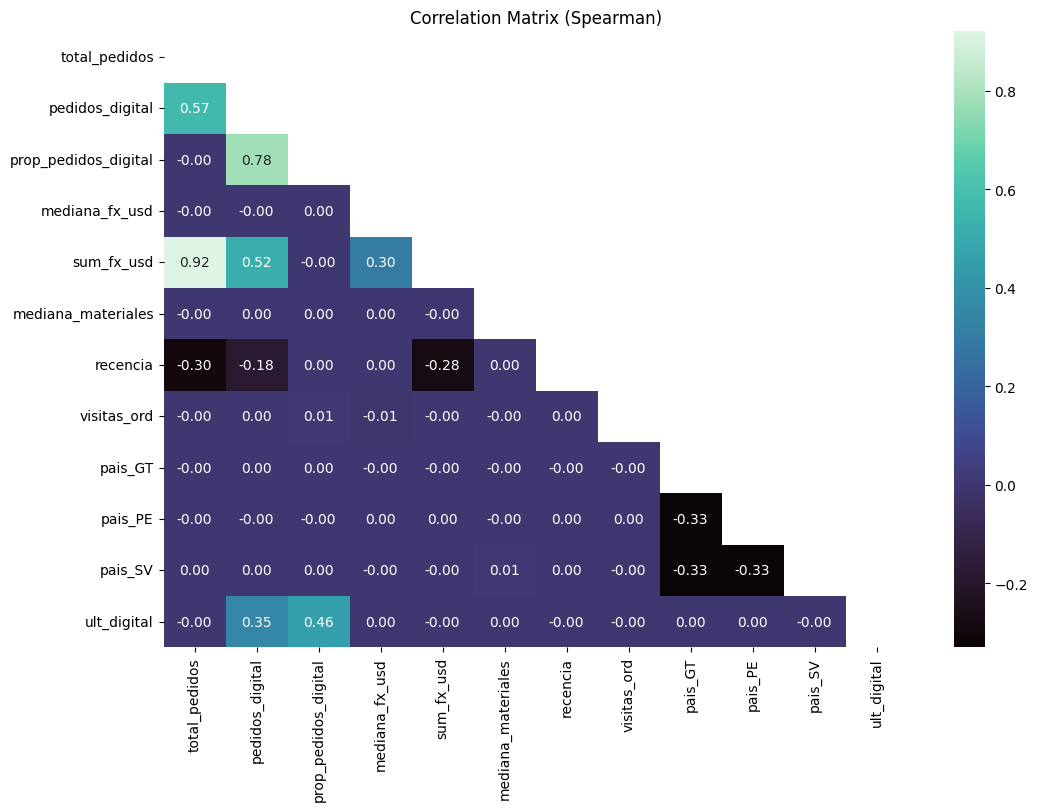

In [27]:
# Visualization of matrix
plt.subplots(figsize=(12, 8))

# Masking the upper triangle
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Final plot
sns.heatmap(matrix, 
            annot=True, 
            cmap="mako", 
            fmt=".2f", 
            mask=mask)

plt.title("Correlation Matrix (Spearman)")
plt.show()

## Feature Importance

A pesar que la matriz de correlación ya proporciona indicios sobre las relaciones fuertes entre variables, la importancia de cada una de ellas será determinada mediante Random Forest.

In [28]:
# Splitting the data set into X and y
X = df_cliente.drop(["cliente_id", "ult_digital"], axis=1)
y = df_cliente["ult_digital"]

# Defining the grid to test on the model
param_dist = {
    "n_estimators":      [100, 200, 300], # no. of trees
    "max_depth":         [None, 6, 10, 15, 20], # max depth of tree
    "min_samples_split": [2, 5, 10], # min number of data points required to split a node in a tree
    "max_features":      ["sqrt", "log2", 1.0] # how many features to consider when splitting. '1.0' is equivalent to all features
}

# Initializing the model and running Randomized Search
rf = RandomForestClassifier(random_state=42) # rf model

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15, # try 30 different combinations of params
    cv=3, # cross-validation with a k of 5
    verbose=2,
    random_state=42,
    n_jobs=-1 # -1 uses all available CPU cores
)

# Fit the model to find the best parameters
random_search.fit(X, y)

# Get the Best Parameters
print("\nBest Parameters:")
print(random_search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=200; total time=  17.3s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=200; total time=  17.3s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=200; total time=  17.5s
[CV] END max_depth=6, max_features=log2, min_samples_split=10, n_estimators=100; total time=   6.0s
[CV] END max_depth=6, max_features=log2, min_samples_split=10, n_estimators=100; total time=   5.9s
[CV] END max_depth=6, max_features=log2, min_samples_split=10, n_estimators=100; total time=   6.7s
[CV] END max_depth=15, max_features=log2, min_samples_split=10, n_estimators=300; total time=  36.7s
[CV] END max_depth=15, max_features=log2, min_samples_split=10, n_estimators=300; total time=  37.1s
[CV] END max_depth=15, max_features=log2, min_samples_split=10, n_estimators=300; total time=  37.4s
[CV] END max_depth=15, max_features=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  28.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  28.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  28.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  47.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  47.7s
[CV] END max_depth=20, max_features=log2, min_samples_split=10, n_estimators=300; total time=  45.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  47.6s
[CV] END max_depth=20, max_features=log2, min_samples_split=10, n_estimators=300; total time=  46.5s
[CV] END max_depth=20, max_features=log2, min_samples_split=10, n_estimators=300; total time=  46.1s
[CV] END max_depth=None, max_features=1.0, min_samples_split=2, n_estimators=200; total time= 

In [29]:
# Final model
best = random_search.best_params_
rf_final = RandomForestClassifier(
    **best,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X, y)

,n_estimators,300
,criterion,'gini'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


prop_pedidos_digital    0.638149
pedidos_digital         0.238972
sum_fx_usd              0.036252
total_pedidos           0.035934
mediana_fx_usd          0.018767
recencia                0.015527
mediana_materiales      0.009129
visitas_ord             0.003452
pais_GT                 0.001352
pais_PE                 0.001237
pais_SV                 0.001229
dtype: float64


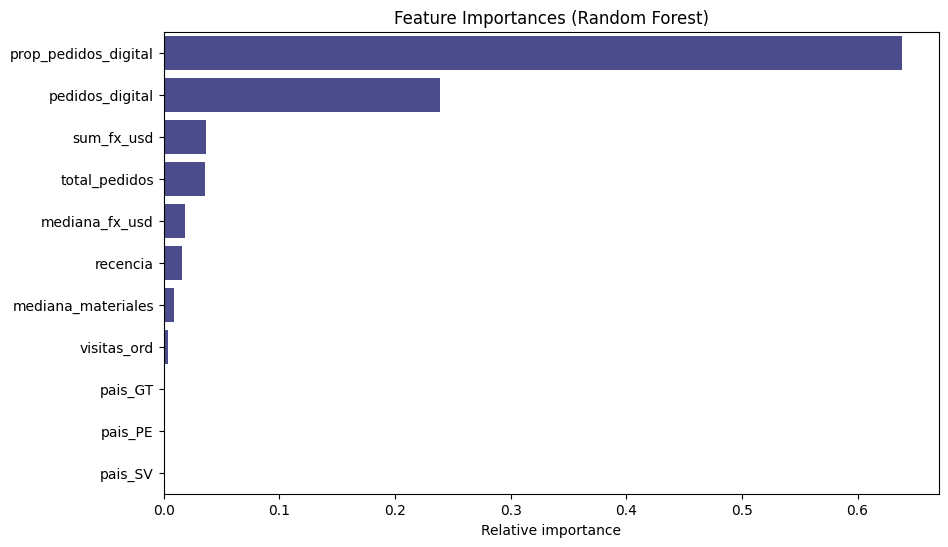

In [30]:
imp = pd.Series(rf_final.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

plt.figure(figsize=(10,6))
sns.barplot(
    x=imp.values, 
    y=imp.index, 
    color="#3f4394"
)
plt.xlabel("Relative importance")
plt.ylabel("")
plt.title("Feature Importances (Random Forest)")
plt.show()

## First Model: Logistic Regression

Los resultados del Feature importance arrojaron luces sobre las variables que explican de mejor forma la varianza de los datos son `prop_pedidos_digital`, `pedidos_digital`, `sum_fx_usd`, por lo que únicamente estas serán tomadas en cuenta para ajustar los modelos. No se usará `total_pedidos` pues sería redundante con la la proporción de pedidos digitales.

In [31]:
# Final df used for modelling
df_final = df_cliente[["prop_pedidos_digital", "pedidos_digital", "sum_fx_usd", "ult_digital"]]
df_final.head()

,prop_pedidos_digital,pedidos_digital,sum_fx_usd,ult_digital
0,1.000000,10,1200.739990,1
1,0.250000,1,493.859985,0
2,0.700000,7,1247.020020,0
3,0.666667,6,1179.530029,0
4,0.545455,6,1238.000000,1


### Standardization of the data

In [32]:
def standardization(df, col):
    """
    Computes the z-score standardization with mean = 0 and std = 1

    Args:
        df: dataset
        col: features to standardize 
    
    Returns
        new columns with standardize values
    """
    ave = df[col].mean()
    std = df[col].std()

    df[f'{col}_std'] = df[col].apply(lambda x: (x-ave)/std)
    return df

In [33]:
for x in list(df_final.columns)[:-1]:
    df_final = standardization(df_final, x)

df_final.head()

/var/folders/qf/ndfr3b6n6y3ctjk46yw6wpvw0000gn/T/ipykernel_21123/2453771838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_std'] = df[col].apply(lambda x: (x-ave)/std)
/var/folders/qf/ndfr3b6n6y3ctjk46yw6wpvw0000gn/T/ipykernel_21123/2453771838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_std'] = df[col].apply(lambda x: (x-ave)/std)
/var/folders/qf/ndfr3b6n6y3ctjk46yw6wpvw0000gn/T/ipykernel_21123/2453771838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a c

,prop_pedidos_digital,pedidos_digital,sum_fx_usd,ult_digital,prop_pedidos_digital_std,pedidos_digital_std,sum_fx_usd_std
0,1.000000,10,1200.739990,1,2.261471,2.577804,0.528459
1,0.250000,1,493.859985,0,-0.998531,-1.286317,-1.360309
2,0.700000,7,1247.020020,0,0.957470,1.289764,0.652118
3,0.666667,6,1179.530029,0,0.812581,0.860417,0.471786
4,0.545455,6,1238.000000,1,0.285712,0.860417,0.628017


### Chebyshev's theorem for anomaly detection

In [34]:
# Selecting only standardized columns
col_std = [col for col in df_final.columns if col.endswith('_std')]

# Keeping the observations among -3 and 3 std. If none, the size of the df stays the same
for x in col_std:
    df_final = df_final[(df_final[x] >= -3) & (df_final[x] <= 3)]

print(f"The size of the data frame now is: {df_final.shape[0]}")

The size of the data frame now is: 147882


El tamaño del df se redujo dada la aplicación del teorema de Chebyshevs. Básicamente toda aquella observación afuera de [-3, 3] desviaciones estándar es tratada como valor atípico y removido

### Test set and Model

In [35]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_final[col_std],
    df_final["ult_digital"],
    test_size=0.25,
    random_state=42
)

El set de entrenamiento corresponde a un 75% de la data, el 25% restante se usará para probar el modelo. Se considera una buena proporción para evitar overfitting

In [36]:
# Creation of the model and training
# Logistic Regression classifier object

## penalty=l2 -> penalization of the complexity of the model. In this case penalize the log-likelihood function with the scaled sum of the squares of the weights (coefficients).
## C=1.0 -> defines the relative strength of regularization. Smaller values equals stronger regularization.
## random_state=42 -> to shuffle the data. Using 0 will produce the same results across different calls.
## solver=lbfgs -> For larger datasets.
lg = LogisticRegression(penalty='l2', C=1.0,
                            random_state=42, solver='lbfgs', max_iter=500)

# Training the model:
lg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [37]:
# Getting beta coefficients
print(lg.classes_)
print(lg.coef_)
print(lg.intercept_)

[0 1]
[[ 1.27786881 -0.18789694  0.10648586]]
[-0.08943837]


### Model Performance and Diagnostic

Accuracy : 0.688
ROC-AUC  : 0.762
              precision    recall  f1-score   support

           0      0.695     0.718     0.706     19287
           1      0.681     0.656     0.668     17684

    accuracy                          0.688     36971
   macro avg      0.688     0.687     0.687     36971
weighted avg      0.688     0.688     0.688     36971



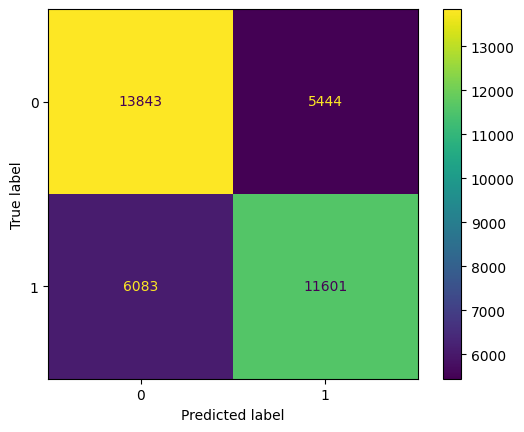

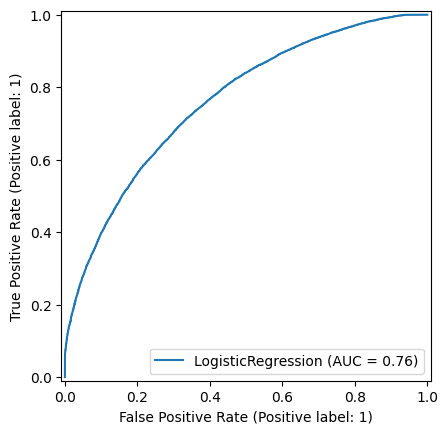

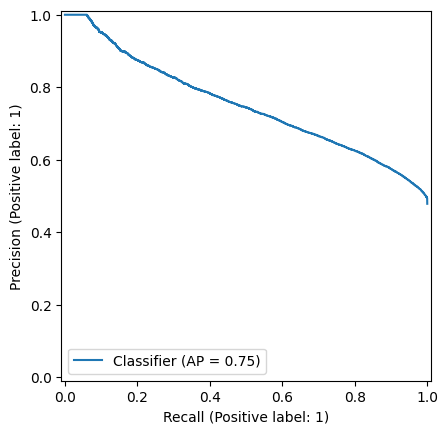

In [38]:
# Testing the model
y_hat = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:, 1]

# Computing performance metrics
print(f"Accuracy : {accuracy_score(y_test, y_hat):.3f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.3f}")
print(classification_report(y_test, y_hat, digits=3))

# Confusion Matrix
conf_m = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay(conf_m).plot()
plt.show()

# ROC and Precision curves
RocCurveDisplay.from_estimator(lg, X_test, y_test) # ROC
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_prob) # Precision
plt.show()


## Second Model: XGBoost

In [39]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_final[["prop_pedidos_digital", "pedidos_digital", "sum_fx_usd"]],
    df_final["ult_digital"],
    test_size=0.30,
    random_state=42
)

In [40]:
# Defining the grid to test on the model
param_dist = {
    'n_estimators': [300, 400, 500, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.2, 0.3],
    'reg_lambda': [0.0, 0.1, 0.2, 0.3]
}

# Initializing the model and running Randomized Search
xgb_cl = xgb.XGBClassifier(objective='binary:logistic',
                            seed=42,
                            use_label_encoder=False,
                            eval_metric='logloss')

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_cl,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter combinations to try
    scoring='roc_auc',
    cv=3,  # Cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the Randomized Search to the training data
random_search.fit(X_train, y_train)

# Getting the Best Parameters
print("Best parameters found: ", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:35:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:35:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:35:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:35:13] WARN

Best parameters found:  {'subsample': 0.9, 'reg_lambda': 0.3, 'reg_alpha': 0.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.9}


In [41]:
# Final XGBoost model
best_xgb = random_search.best_estimator_

# Getting predictions with best params
y_hat_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

### Model Performance and Diagnostic

Accuracy : 0.689
ROC-AUC  : 0.761
              precision    recall  f1-score   support

           0      0.687     0.742     0.714     23211
           1      0.690     0.630     0.659     21154

    accuracy                          0.689     44365
   macro avg      0.689     0.686     0.686     44365
weighted avg      0.689     0.689     0.688     44365



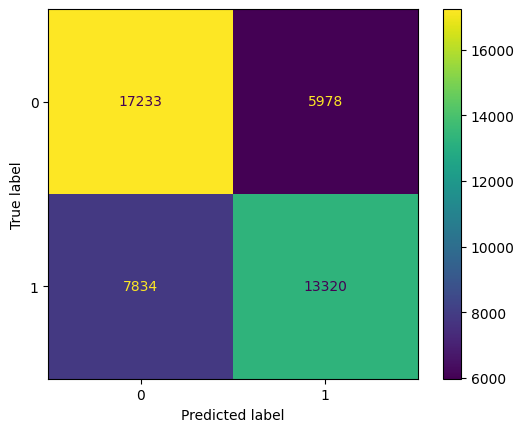

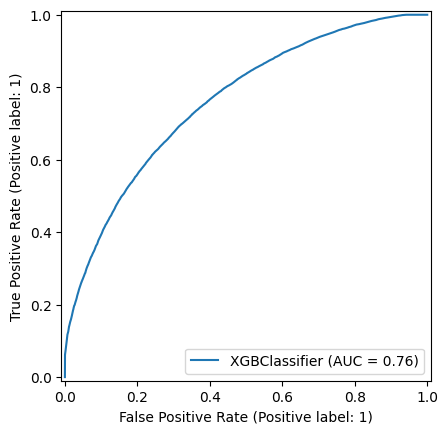

In [42]:
# Computing performance metrics
print(f"Accuracy : {accuracy_score(y_test, y_hat_xgb):.3f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob_xgb):.3f}")
print(classification_report(y_test, y_hat_xgb, digits=3))

# Confusion Matrix
conf_m_xgb = confusion_matrix(y_test, y_hat_xgb)
ConfusionMatrixDisplay(conf_m_xgb).plot()
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)
plt.show()